# Fake news prediction model

## Dependencies

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

## Data processing

### Loading the cleaned data

In [19]:
from tqdm import tqdm
# Set a chunk size (e.g., 1000 rows per chunk, adjust based on file size)
chunk_size = 1000
rows = 868346
chunks = []

# Use tqdm to show progress while iterating over chunks
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("1.000.000 cleaned/data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(chunk_size)

# Combine all chunks into a single DataFrame
df = pd.concat(chunks)

train_data = pd.read_csv("1.000.000 cleaned/data_cleaned_fr.csv")

Loading csv file: 869000it [00:20, 43312.85it/s]                            


### Distribution

In [20]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 868346
Fake article amount: 294621
Reliable article amount: 573725
Reliable percentage: 66.07%


### Splitting

In [21]:
X = train_data['content']
y = train_data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Vectorization

In [22]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
reliable    458979
fake        235697
Name: count, dtype: int64
Test class distribution:
type
reliable    114746
fake         58924
Name: count, dtype: int64


### Over sampling

In [23]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
reliable    458979
fake        458979
Name: count, dtype: int64


## Training and evaluation

### Model training

In [24]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(1000, 500, 100, 25),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.18997619
Iteration 2, loss = 0.16477366
Iteration 3, loss = 0.07989589
Iteration 4, loss = 0.05245725
Iteration 5, loss = 0.02993363
Iteration 6, loss = 0.01906465
Iteration 7, loss = 0.01426501
Iteration 8, loss = 0.01242087
Iteration 9, loss = 0.01132408
Iteration 10, loss = 0.01045734
Iteration 11, loss = 0.00931153
Iteration 12, loss = 0.00937104
Iteration 13, loss = 0.00935105
Iteration 14, loss = 0.00887783
Iteration 15, loss = 0.00877105
Iteration 16, loss = 0.00827833
Iteration 17, loss = 0.00823905
Iteration 18, loss = 0.00725140
Iteration 19, loss = 0.00616509
Iteration 20, loss = 0.00601790
Iteration 21, loss = 0.00557775
Iteration 22, loss = 0.00538615
Iteration 23, loss = 0.00544940
Iteration 24, loss = 0.00529768
Iteration 25, loss = 0.00551603
Iteration 26, loss = 0.00533579
Iteration 27, loss = 0.00522610
Training loss did not improve more than tol=0.000100 for 4 consecutive epochs. Stopping.


MLPClassifier(batch_size=1024, hidden_layer_sizes=(1000, 500, 100, 25),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

### Evaluation

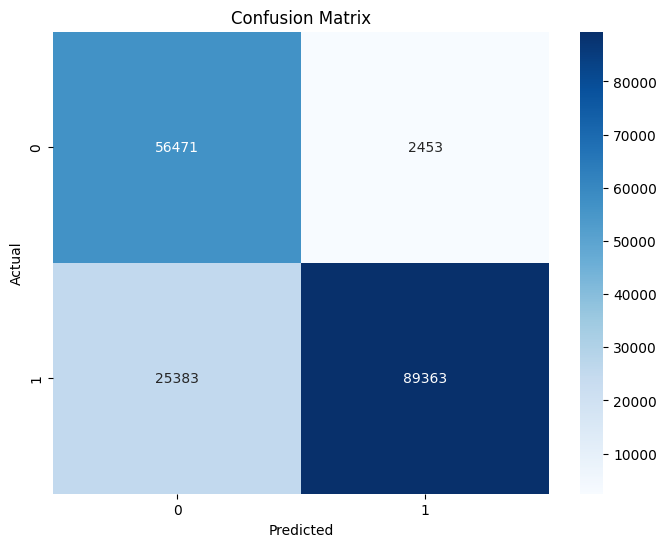

              precision    recall  f1-score   support

        fake       0.69      0.96      0.80     58924
    reliable       0.97      0.78      0.87    114746

    accuracy                           0.84    173670
   macro avg       0.83      0.87      0.83    173670
weighted avg       0.88      0.84      0.84    173670



In [25]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))